In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
np.random.seed(0)
import random
import json
import pandas as pd
from datetime import datetime, timedelta

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs


# 项目结论

# Thinking Engine data


Dispute monitoring report:

http://td.winnerstudio.vip:8996/#/panel/panel/39_3423



## Time since payment and install

- Time since payment: http://td.winnerstudio.vip:8996/#/tga/ide/59_22269?tab=result

- Time since install: http://td.winnerstudio.vip:8996/#/tga/ide/59_22267


Next steps: 

- Can u find the dispute ID? 
- Then from that try to find out why a unique payment is associated to multiple rows? 
- Then check if after correcting this the join of predictions and regressors does not generate a movement in the rows of the response dataset. 
- Apply corrections across the analysis including the dashboards

# Response

The objective also is to find the measure of success. So the model needs to fit well the probabilities over time.

DECISION I 

- Consider only payments before the last 60 days: Reason, some of those payments can be succeptible of being disputed but hav enot been disputed yet. 
- Consider only payers that installed the game after september: Maybe before september it is too early 
- Acorn casino iOS: Only iOS version is active

In [320]:
# "C:\Users\Win11\Downloads\20240311_064424_09284_d6nuy.csv"
response_data = pd.read_csv('C:/Users/Win11/Downloads/20240311_064424_09284_d6nuy.csv')


In [321]:
response_data.sample(10)

,#account_id,register_time,payment_date,user_matuirity,first_payment_time,first_dispute_time,pull_size,time_to_payment,time_pay_to_dispute,time_to_dispute,...,finished_playing,money_games_working_hours,bet_money,max_bet,money_games_last_7d,money_games_last_14d,bet_money_last_7d,bet_money_last_14d,chip_games_last_14d,money_games_working_hours_last_14d
717043,10284879,2024-01-14 14:08:04.000,2024-02-10,26,2024-01-15 19:05:15.610,NaN,2199324,72,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479499,10083359,2023-12-09 20:06:40.000,2024-01-09,30,2023-12-09 20:14:06.914,NaN,2199324,0,NaN,NaN,...,2024-01-09 20:33:30.224,33.0,17.90,0.3,166.0,166.0,19.34,19.34,938.0,33.0
756256,10202951,2024-01-01 06:14:51.000,2024-01-18,16,2024-01-01 06:17:22.864,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749808,10183788,2023-12-29 00:24:01.000,2024-02-07,39,2023-12-29 00:27:02.296,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,2853.0,0.04,819.61,101.0,610.0
124251,10084417,2023-12-10 00:34:32.000,2024-01-02,22,2023-12-10 00:42:28.874,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171542,10067814,2023-12-05 17:28:08.000,2024-01-05,30,2023-12-13 23:00:38.416,NaN,2199324,493,NaN,NaN,...,NaN,NaN,NaN,NaN,17.0,48.0,14.50,22.30,16.0,16.0
683164,10124582,2023-12-17 16:56:35.000,2024-01-17,30,2023-12-17 17:33:09.534,NaN,2199324,1,NaN,NaN,...,2024-01-17 19:08:41.897,10.0,12.35,0.2,116.0,3138.0,21.05,521.14,1041.0,1017.0
734785,10179980,2023-12-28 09:45:22.000,2024-01-31,33,2023-12-28 09:47:57.514,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458535,10235477,2024-01-06 21:04:30.000,2024-02-01,25,2024-01-06 21:14:53.947,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
627389,10098582,2023-12-12 19:43:54.000,2024-01-20,38,2023-12-12 19:46:41.094,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Measure of performance

In [132]:
validation_sets = 3
response_data['date'] = pd.to_datetime(response_data['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
response_data['validation_set_id'] = pd.qcut(response_data['date'].values, validation_sets)
response_data.groupby('validation_set_id').size()

validation_set_id
(20231101.999, 20231213.0]    275971
(20231213.0, 20231229.0]      269032
(20231229.0, 20240125.0]      259344
dtype: int64

DECISION III: Who is a disputer

In [133]:
response_data['disputer'] = (response_data['dispute_rate'] > 0).astype(int)
payment_cols = ['valid_payments', 'disputer']
response_data['disputer'].mean()

KeyError: 'dispute_rate'

# Predictors

Pull and join them. It is okay.

 - You can use basic PLTV data: Withdrawal, etc.
 - Activity

In [322]:
# result = pd.merge(response_data, predictors, on = '#account_id', how = 'inner')
result = response_data.copy(deep = True)

In [323]:
result['user_matuirity'].unique()

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40], dtype=int64)

In [324]:
result['disputer'] = (result['disputer_lt_30d'] > 0).astype(int)
result['disputer'] =  result['disputer_lt_30d']
# result['disputer'] = (~response_data['first_dispute_time'].isnull()).astype(int)
result.sample(10)



,#account_id,register_time,payment_date,user_matuirity,first_payment_time,first_dispute_time,pull_size,time_to_payment,time_pay_to_dispute,time_to_dispute,...,money_games_working_hours,bet_money,max_bet,money_games_last_7d,money_games_last_14d,bet_money_last_7d,bet_money_last_14d,chip_games_last_14d,money_games_working_hours_last_14d,disputer
310877,10118954,2023-12-16 16:35:41.000,2024-01-22,36,2023-12-16 16:36:59.052,NaN,2199324,0,NaN,NaN,...,28.0,239.95,5.0,6727.0,9716.0,6023.14,10719.11,314.0,2887.0,0
691400,10136726,2023-12-19 19:05:34.000,2024-01-17,28,2023-12-19 19:09:16.694,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
448221,10218584,2024-01-03 21:14:24.000,2024-01-21,17,2024-01-06 22:32:39.013,NaN,2199324,183,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
241564,10186138,2023-12-29 08:58:29.000,2024-02-06,38,2023-12-29 09:03:45.010,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,58.0,58.0,38.10,38.10,0.0,58.0,0
520007,10084049,2023-12-09 23:11:26.000,2024-01-16,37,2023-12-09 23:15:52.686,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
417919,10149619,2023-12-22 04:44:46.000,2024-01-30,38,2023-12-22 04:53:34.586,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
140897,10146551,2023-12-21 16:49:53.000,2024-01-27,36,2023-12-21 16:58:32.081,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,7.0,NaN,0.70,198.0,0.0,0
613774,10301150,2024-01-17 00:09:46.000,2024-02-05,18,2024-01-17 00:11:29.842,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
657154,10323481,2024-01-20 15:10:47.000,2024-02-06,16,2024-01-20 15:13:27.509,NaN,2199324,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
598275,10252996,2024-01-09 13:44:35.000,2024-01-31,21,2024-01-12 01:30:11.491,NaN,2199324,149,NaN,NaN,...,NaN,NaN,NaN,3.0,3.0,0.30,0.30,414.0,0.0,0


# Trainning

In [325]:
# Generate a function that generates the log of a list of column names in a dataframe:
cols = ['spent_to_date', 'max_payment', 'payments_to_date', 'user_matuirity', 'payments_last_7_days', 'spent_last_7_days', 'max_payment_in_day', 'std_payments']

column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date', 'bet_money_last_7d', 'bet_money_last_14d', 'money_games_last_7d', 'money_games_last_14d', 'chip_games_last_14d']
def log_transform_columns(df, column_names):
    new_columns = []
    for col in column_names:
        new_col_name = f'l_{col}'
        df[new_col_name] = np.log(df[col])
        new_columns.append(new_col_name)
    return df, new_columns
result, logs_columns = log_transform_columns(result, column_names)
print(logs_columns)


# Generate a function that divides all the columns in a list by the columns in another list:
def divide_columns(df, dividend_columns, divisor_columns):
    new_columns = []
    for dividend_col, divisor_col in zip(dividend_columns, divisor_columns):
        new_col_name = f'ratio_{dividend_col}_to_{divisor_col}'
        df[new_col_name] = df[dividend_col] / df[divisor_col]
        new_columns.append(new_col_name)
    return df, new_columns

dividend_columns = ['spent_to_date']
divisor_columns = ['user_matuirity', 'payments_to_date']
result, ratios_columns_1 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_1)

dividend_columns = ['max_payment_in_day', 'max_payment']
divisor_columns = ['spent_to_date', 'payments_to_date']
result, ratios_columns_2 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_2)

dividend_columns = ['money_games_working_hours_last_14d']
divisor_columns = ['money_games_last_14d']
result, ratios_columns_3 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_3)

# Generate a function that generates all the multiplications between the columns in a dataframe
def generate_multiplications(df):
    new_columns = []
    columns = df.columns
    for i, col1 in enumerate(columns):
        for col2 in columns[i + 1:]:
            new_col_name = f'{col1}_x_{col2}'
            df[new_col_name] = df[col1] * df[col2]
            new_columns.append(new_col_name)
    return df, new_columns
# result, interacations_columns = generate_multiplications(result, column_names)


# Generate a function that generates k dummy variables in each column in list, where k is the number of quantiles - 1. The lowest quantile is left
column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date', 'max_bet']
def generate_quantile_dummies(df, column_names, num_quantiles):
    new_columns = []
    for col in column_names:
        quantiles = df[col].quantile(np.linspace(0, 1, num_quantiles + 1)).reset_index(drop = True)
        for i in range(1, num_quantiles):
            new_col = f'{col}_quantile_{i}'
            df[new_col] = (df[col] > quantiles[i-1]).astype(int)
            new_columns.append(new_col)
    return df, new_columns
result, quantile_columns = generate_quantile_dummies(result, column_names, num_quantiles = 10)
print(quantile_columns)

# Generate a function that generates a dummy variable in each column in list, where 1 if the value is an outlier, and 0 otherwise.
column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date']
def generate_outlier_dummies(df, column_names):
    new_columns = []
    for col in column_names:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        new_col_name = f'{col}_outlier'
        df[new_col_name] = ((df[col] < lower_bound) | (df[col] > upper_bound)).astype(int)
        new_columns.append(new_col_name)
    return df, new_columns
result, outlier_columns = generate_outlier_dummies(result, column_names)
print(outlier_columns)


['l_spent_to_date', 'l_spent_last_7_days', 'l_payments_to_date', 'l_bet_money_last_7d', 'l_bet_money_last_14d', 'l_money_games_last_7d', 'l_money_games_last_14d', 'l_chip_games_last_14d']
['ratio_spent_to_date_to_user_matuirity']
['ratio_max_payment_in_day_to_spent_to_date', 'ratio_max_payment_to_payments_to_date']
['ratio_money_games_working_hours_last_14d_to_money_games_last_14d']
['spent_to_date_quantile_1', 'spent_to_date_quantile_2', 'spent_to_date_quantile_3', 'spent_to_date_quantile_4', 'spent_to_date_quantile_5', 'spent_to_date_quantile_6', 'spent_to_date_quantile_7', 'spent_to_date_quantile_8', 'spent_to_date_quantile_9', 'spent_last_7_days_quantile_1', 'spent_last_7_days_quantile_2', 'spent_last_7_days_quantile_3', 'spent_last_7_days_quantile_4', 'spent_last_7_days_quantile_5', 'spent_last_7_days_quantile_6', 'spent_last_7_days_quantile_7', 'spent_last_7_days_quantile_8', 'spent_last_7_days_quantile_9', 'payments_to_date_quantile_1', 'payments_to_date_quantile_2', 'payments_t

In [326]:
result['spent_to_date'].quantile(np.linspace(0, 1, 7 + 1)).reset_index(drop = True)

0         1.000000
1         2.990000
2         5.000000
3        10.000000
4        20.000000
5        42.000000
6       137.994286
7    249378.140000
Name: spent_to_date, dtype: float64

In [327]:
# cols = ['max_spent', 'daily_spent', 'spent_deviation', 'spent_ratio', 'time_to_payment', 'payments']
cols = ['spent_to_date', 'payments_to_date', 'user_matuirity', 'payments_last_7_days', 'spent_last_7_days', 'max_payment_in_day', 'std_payments'] + logs_columns + ratios_columns_1 + ratios_columns_2 + ratios_columns_3 + quantile_columns + outlier_columns

print(cols)

print(len(result[cols].columns))
# time_pay_to_dispute	time_to_dispute	payments_to_date	payments_last_7_days	spent_last_7_days	spent_to_date	max_payment	max_payment_in_day	std_payments	disputer_lt_30d
result = result.replace([np.inf, -np.inf, np.nan], 0)
print(len(result[cols].columns))

result.loc[:, (result != result.iloc[0]).any()]
len(result[cols].columns)


['spent_to_date', 'payments_to_date', 'user_matuirity', 'payments_last_7_days', 'spent_last_7_days', 'max_payment_in_day', 'std_payments', 'l_spent_to_date', 'l_spent_last_7_days', 'l_payments_to_date', 'l_bet_money_last_7d', 'l_bet_money_last_14d', 'l_money_games_last_7d', 'l_money_games_last_14d', 'l_chip_games_last_14d', 'ratio_spent_to_date_to_user_matuirity', 'ratio_max_payment_in_day_to_spent_to_date', 'ratio_max_payment_to_payments_to_date', 'ratio_money_games_working_hours_last_14d_to_money_games_last_14d', 'spent_to_date_quantile_1', 'spent_to_date_quantile_2', 'spent_to_date_quantile_3', 'spent_to_date_quantile_4', 'spent_to_date_quantile_5', 'spent_to_date_quantile_6', 'spent_to_date_quantile_7', 'spent_to_date_quantile_8', 'spent_to_date_quantile_9', 'spent_last_7_days_quantile_1', 'spent_last_7_days_quantile_2', 'spent_last_7_days_quantile_3', 'spent_last_7_days_quantile_4', 'spent_last_7_days_quantile_5', 'spent_last_7_days_quantile_6', 'spent_last_7_days_quantile_7', 'sp

58


58

In [328]:
cols
result['ratio_money_games_working_hours_last_14d_to_money_games_last_14d']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
804342    0.0
804343    0.0
804344    0.0
804345    0.0
804346    0.0
Name: ratio_money_games_working_hours_last_14d_to_money_games_last_14d, Length: 804347, dtype: float64

In [329]:
'ratio_money_games_working_hours_last_14d_to_money_games_last_14d' in cols

True

# Exploration of overfit

In [176]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

def create_model(criterion, depth, leaf_size):

    # preprocessor = ColumnTransformer(
    #     transformers = [
    #         ('scaler', StandardScaler(), cols)
    #     ],
    #     remainder='passthrough'
    # )

    # Create the pipeline
    pipe = Pipeline([
        # ('preprocessor', preprocessor),
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
        # ('regressor', RandomForestClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe


In [178]:
X_train[cols]
result[cols]
payment_cols
len(X_train[cols].columns)
result[cols].columns
payment_cols
cols

KeyError: "['l_bet_money_last_7d', 'l_bet_money_last_14d', 'l_money_games_last_7d', 'l_money_games_last_14d', 'l_chip_games_last_14d', 'spent_to_date_quantile_3', 'spent_to_date_quantile_4', 'spent_to_date_quantile_5', 'spent_to_date_quantile_6', 'spent_to_date_quantile_7', 'spent_to_date_quantile_8', 'spent_to_date_quantile_9', 'spent_last_7_days_quantile_3', 'spent_last_7_days_quantile_4', 'spent_last_7_days_quantile_5', 'spent_last_7_days_quantile_6', 'spent_last_7_days_quantile_7', 'spent_last_7_days_quantile_8', 'spent_last_7_days_quantile_9', 'payments_to_date_quantile_3', 'payments_to_date_quantile_4', 'payments_to_date_quantile_5', 'payments_to_date_quantile_6', 'payments_to_date_quantile_7', 'payments_to_date_quantile_8', 'payments_to_date_quantile_9', 'max_bet_quantile_1', 'max_bet_quantile_2', 'max_bet_quantile_3', 'max_bet_quantile_4', 'max_bet_quantile_5', 'max_bet_quantile_6', 'max_bet_quantile_7', 'max_bet_quantile_8', 'max_bet_quantile_9'] not in index"

In [179]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['log_loss']
depths = [5]
leaf_sizes = [350]
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    # train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]
    train_data =  result[result['validation_set_id'] == date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    # old_cols = X_train.copy().columns
    # X_train = all_feature_enginerring(X_train, y_train)
    # X_test = all_feature_enginerring(X_test, y_test)

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)

              # try:
              #     model.fit(X_train[cols], y_train)
              #     predictions = model.predict(X_test[cols])
              #     accuracy = accuracy_score(y_test, predictions)
              #     prec = precision_score(y_test, predictions)

              # except:
              #     model = np.nan
              #     predictions = np.nan
              #     mae = np.nan
              #     r2 = np.nan

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])

100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


In [180]:
# all_model_results.groupby(['Iteration', 'Test at', 'Model']).mean()
amrgb = all_model_results.groupby('Iteration')[['accuracy', 'precission']].mean().sort_values(by = 'accuracy', ascending = False).reset_index(drop = False)
amrgb


,Iteration,accuracy,precission
0,log_loss - 5 - 350,0.995508,0.0


In [181]:
all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 350']['Model'].values[0]

Pipeline(steps=[('regressor',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=5,
                                        min_samples_leaf=350))])

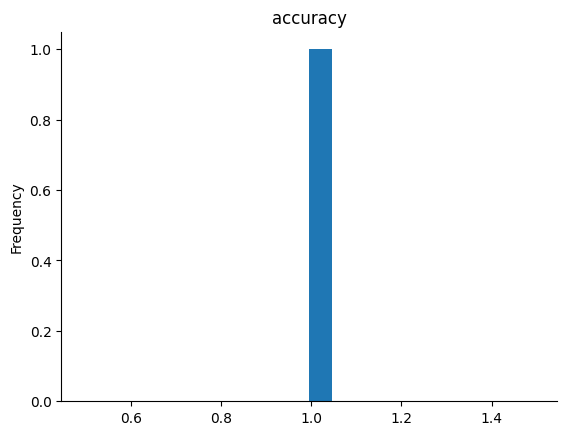

In [182]:
# @title accuracy

from matplotlib import pyplot as plt
all_model_results['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

['spent_to_date', 'payments_to_date', 'user_matuirity', 'payments_last_7_days', 'spent_last_7_days', 'max_payment_in_day', 'std_payments', 'l_spent_to_date', 'l_spent_last_7_days', 'l_payments_to_date', 'l_bet_money_last_7d', 'l_bet_money_last_14d', 'l_money_games_last_7d', 'l_money_games_last_14d', 'l_chip_games_last_14d', 'ratio_spent_to_date_to_user_matuirity', 'ratio_max_payment_in_day_to_spent_to_date', 'ratio_max_payment_to_payments_to_date', 'spent_to_date_quantile_1', 'spent_to_date_quantile_2', 'spent_to_date_quantile_3', 'spent_to_date_quantile_4', 'spent_to_date_quantile_5', 'spent_to_date_quantile_6', 'spent_to_date_quantile_7', 'spent_to_date_quantile_8', 'spent_to_date_quantile_9', 'spent_last_7_days_quantile_1', 'spent_last_7_days_quantile_2', 'spent_last_7_days_quantile_3', 'spent_last_7_days_quantile_4', 'spent_last_7_days_quantile_5', 'spent_last_7_days_quantile_6', 'spent_last_7_days_quantile_7', 'spent_last_7_days_quantile_8', 'spent_last_7_days_quantile_9', 'paymen

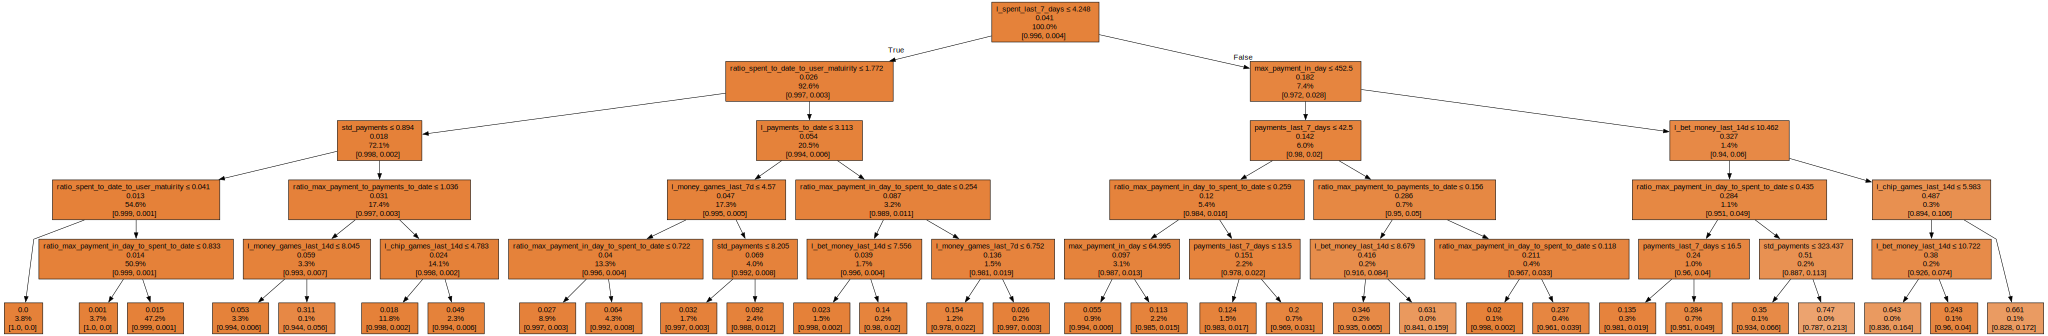

In [183]:
# from sklearn import tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier
clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 350']['Model'].values[0][0]

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

print(cols)
# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)
# print(dot_data)



If approapiate you can rebalance the number of users

In [ ]:
response_data[response_data['daily_spent'] >= 53.274][response_data['spent_deviation'] <= 4.622].head(20)
response_data[response_data['daily_spent'] >= 53.274][response_data['payments'] <= 7.5].head(20)
response_data[response_data['daily_spent'] > 18.215][response_data['payments'] <= 3.5].head(20)
# response_data[response_data['daily_spent'] > 18.215][response_data['payments'] <= 3.5]

The conclusion is that the model looks for high payers, and it barely cares about withdrawal patterns.

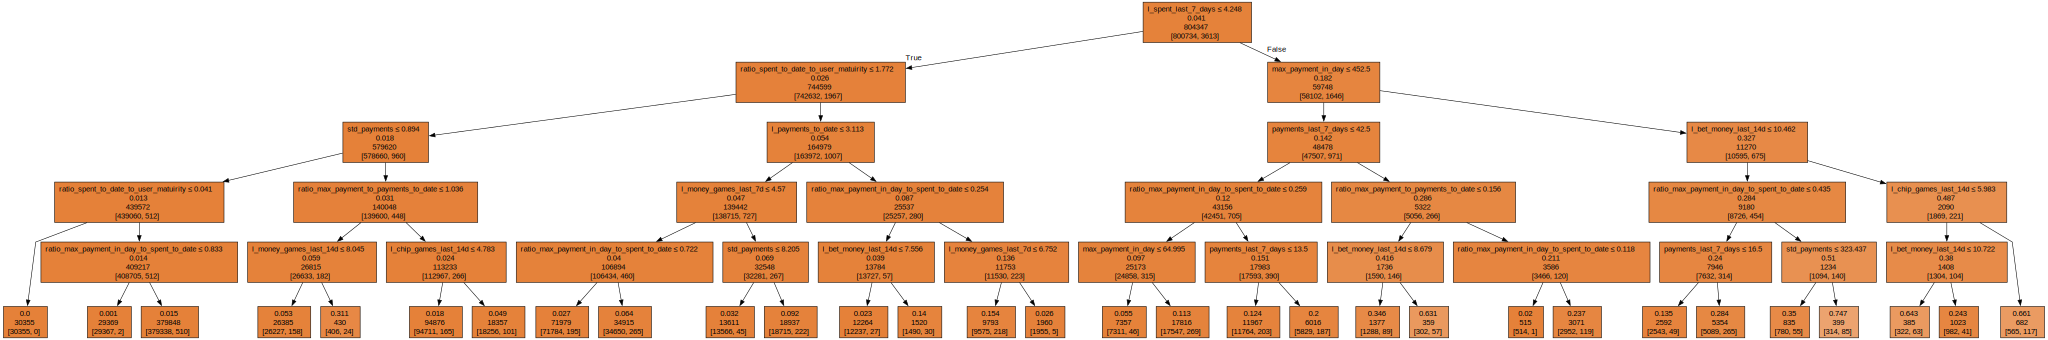

In [184]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled = True
                           ,  leaves_parallel = True
                          #  ,  proportion = True
                           ,  rounded = False
                           ,  special_characters = True)

graphviz.Source(dot_data)



# Calibration curves

In [185]:
validation_sets = 3
# result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
# result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()

validation_set_id
(20231101.999, 20231213.0]    275971
(20231213.0, 20231229.0]      269032
(20231229.0, 20240125.0]      259344
dtype: int64

In [186]:
result['validation_set_id'].unique()

[(20231101.999, 20231213.0], (20231213.0, 20231229.0], (20231229.0, 20240125.0]]
Categories (3, interval[float64, right]): [(20231101.999, 20231213.0] < (20231213.0, 20231229.0] < (20231229.0, 20240125.0]]

In [187]:

train_data =  result[result['validation_set_id'] != result['validation_set_id'].unique()[2]][payment_cols]
test_data =  result[result['validation_set_id'] == result['validation_set_id'].unique()[2]][payment_cols]

X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

# X_train.sample(5)
X_test.sample(5)

,spent_to_date,payments_to_date,user_matuirity,payments_last_7_days,spent_last_7_days,max_payment_in_day,std_payments,l_spent_to_date,l_spent_last_7_days,l_payments_to_date,...,max_bet_quantile_3,max_bet_quantile_4,max_bet_quantile_5,max_bet_quantile_6,max_bet_quantile_7,max_bet_quantile_8,max_bet_quantile_9,spent_to_date_outlier,spent_last_7_days_outlier,payments_to_date_outlier
756854,3.00,1,27,0,0.0,3.00,0.000000,1.098612,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
397975,11.00,3,17,1,3.0,7.00,3.055050,2.397895,1.098612,1.098612,...,1,0,0,0,0,0,0,0,0,0
324824,5.99,2,18,0,0.0,5.99,0.000000,1.790091,0.000000,0.693147,...,1,0,0,0,0,0,0,0,0,0
748196,138.99,22,18,7,35.0,29.00,8.188396,4.934402,3.555348,3.091042,...,0,0,0,0,0,0,0,1,0,1
546233,3.00,1,17,0,0.0,3.00,0.000000,1.098612,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [189]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

# class_weight
lr              = LogisticRegression(C = 1.0, max_iter = 180, n_jobs = 5)
lr              = LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5)
# I want a model  

# gnb_isotonic    = CalibratedClassifierCV(gnb, cv = 2, method="isotonic")
# gnb_sigmoid     = CalibratedClassifierCV(gnb, cv = 2, method="sigmoid")
# Random_Forest_1 = RandomForestClassifier(min_samples_leaf = 25, n_jobs = 5)
Random_Forest_40 = RandomForestClassifier(min_samples_leaf = 40, n_jobs = 5)
Random_Forest_200 = RandomForestClassifier(min_samples_leaf = 200, n_jobs = 5)
dt              = DecisionTreeClassifier(min_samples_leaf = 350)

clf_list = [
    (lr, "Logistic")
    , (dt, "Classification Tree")
    , (Random_Forest_40, "Random_Forest_40")
    , (Random_Forest_200, "Random_Forest_200")
]

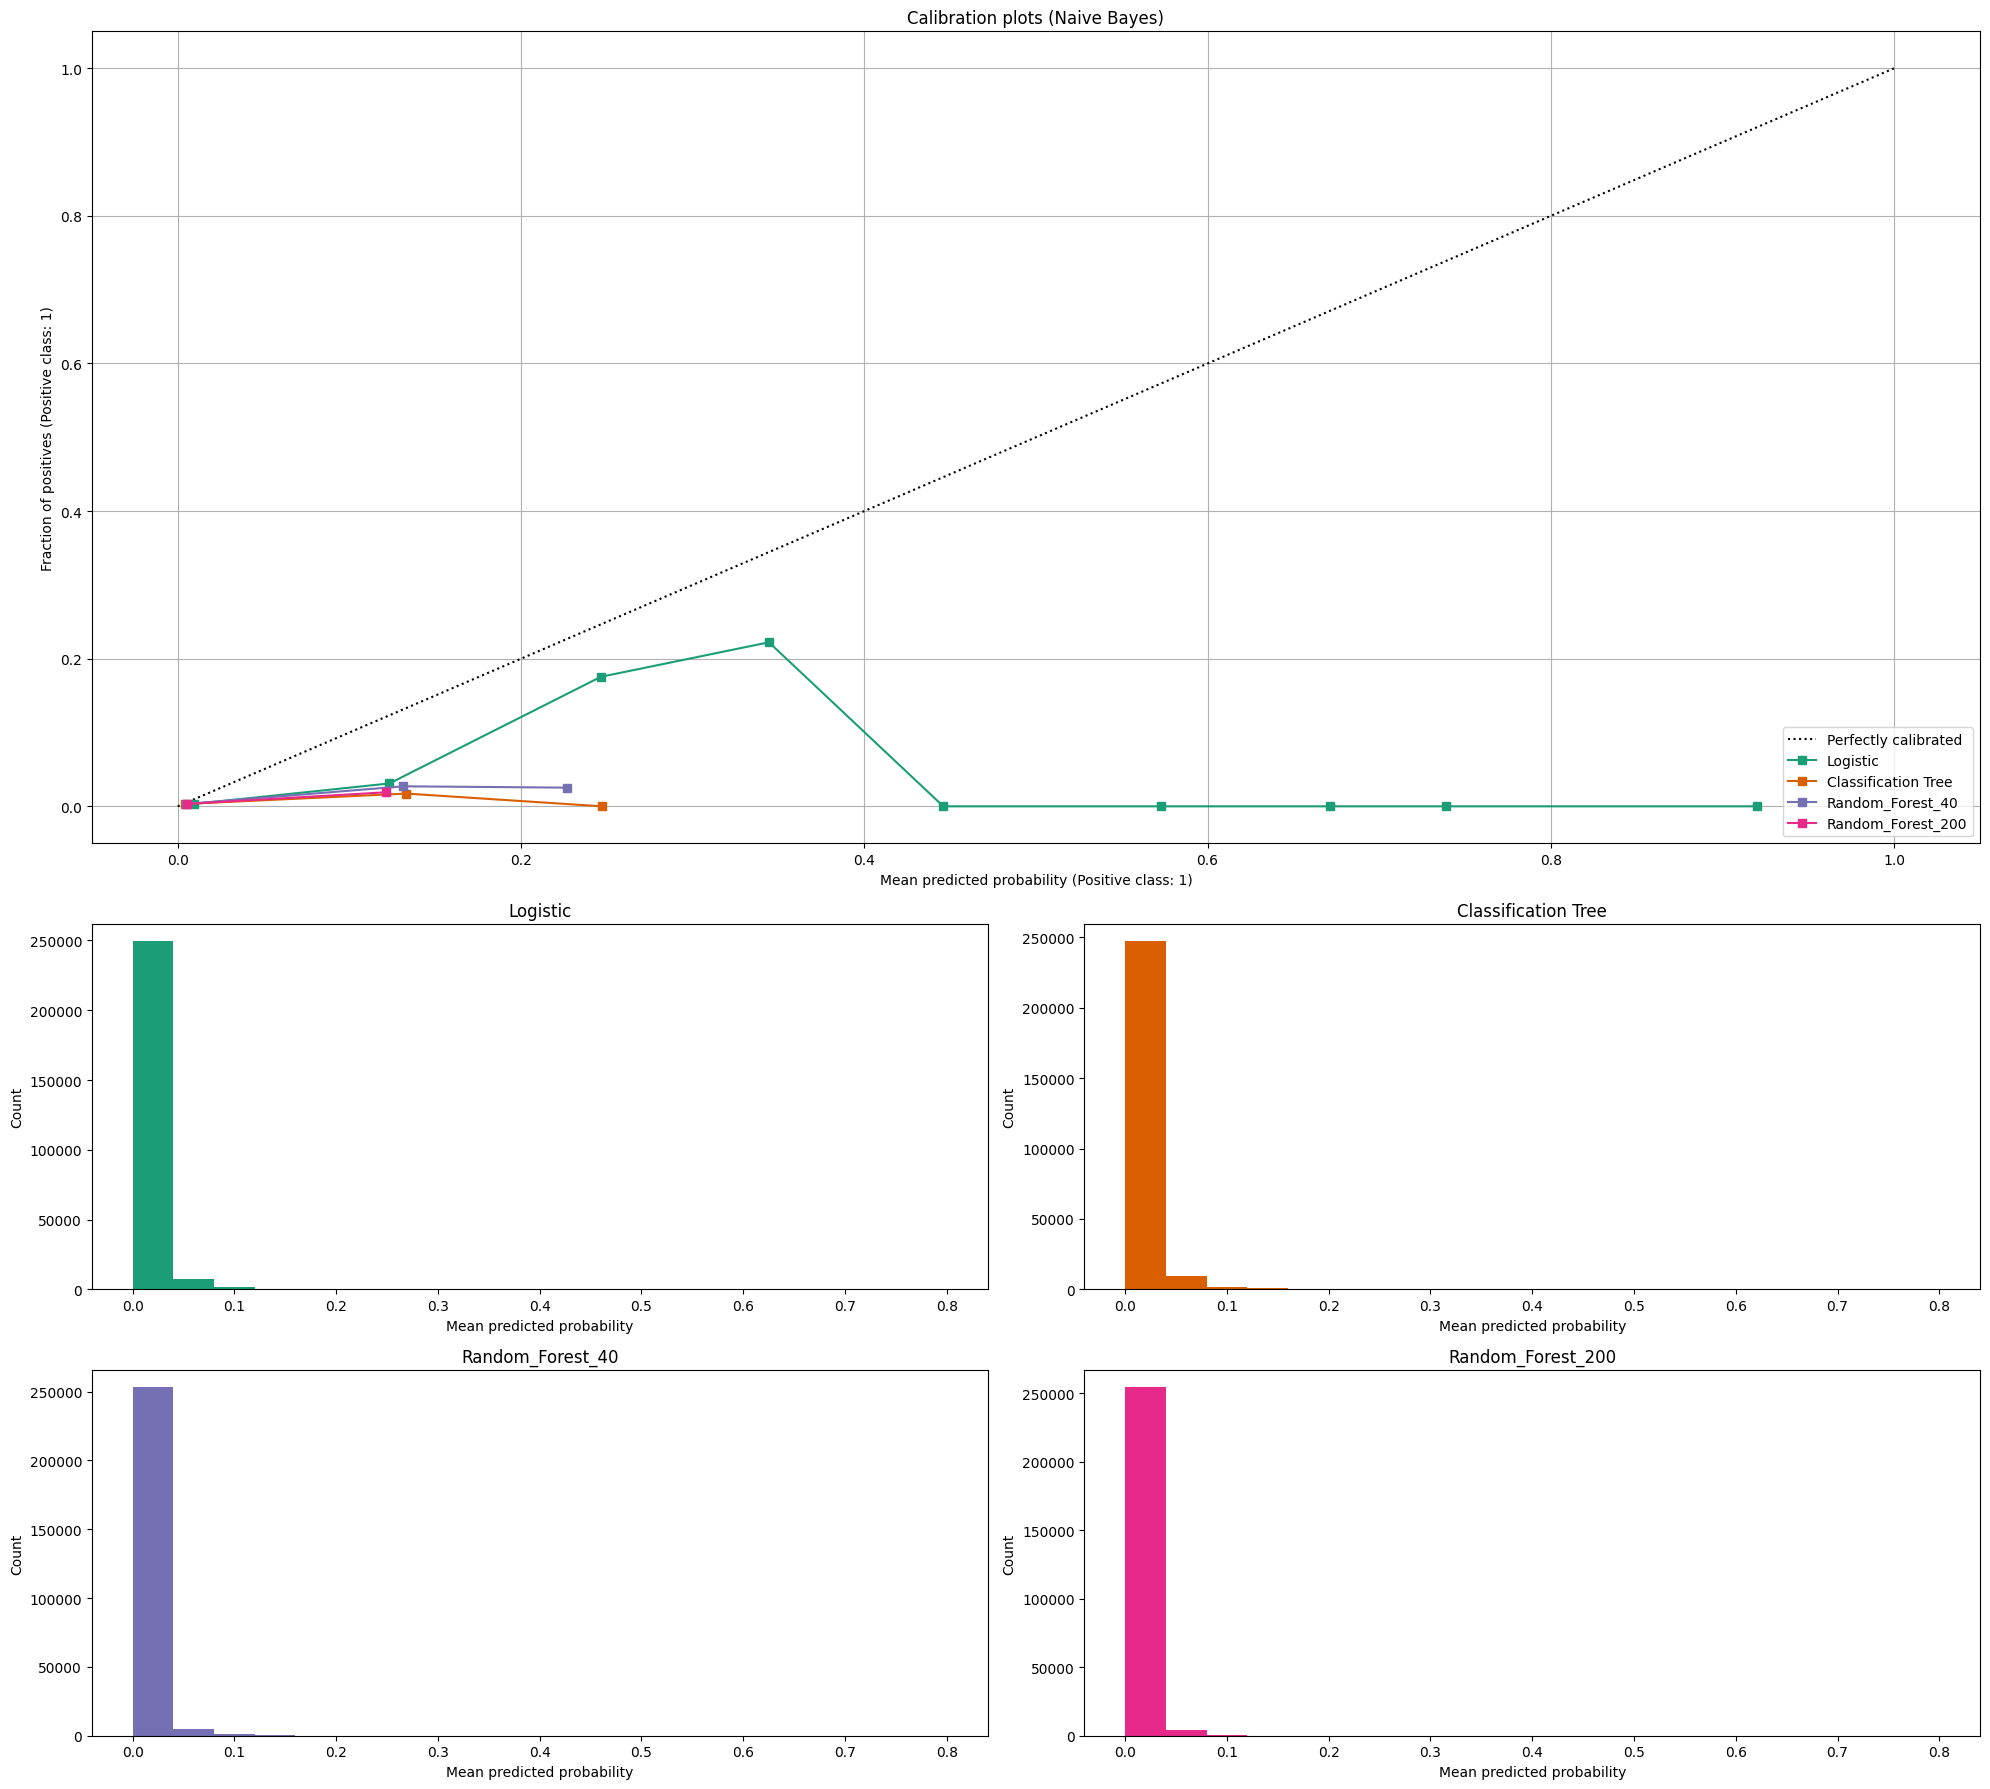

In [190]:
fig = plt.figure(figsize=(20, 18))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")
fitted_models = {}

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    fitted_models[name] = clf

    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins = 10,
        name = name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 0.8),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

# I want to add more details to the plot 

plt.tight_layout()
plt.show()

In [57]:
Random_Forest_1.fit(X_train[cols], y_train)
predictions = Random_Forest_1.predict(X_test[cols])
prob_predictions = Random_Forest_1.predict_proba(X_test[cols])
accuracy = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions)


In [58]:
predictions
prob_predictions[:, 1].max()

0.5177635281705086

In [59]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.004552,0.032671,0.603590,0.099099,0.01028,0.018628
Classification Tree,0.004543,0.107495,0.566794,0.000000,0.00000,0.000000
Random_Forest_complex,0.004263,0.034345,0.723693,0.000000,0.00000,0.000000


In [60]:
X_test

,spent_to_date,max_payment,payments_to_date,user_matuirity,payments_last_7_days,spent_last_7_days,max_payment_in_day,std_payments
562473,127.98,29.99,14,43,0,0.0,83.98,33.139343
562474,127.98,29.99,14,42,0,0.0,83.98,33.139343
562475,127.98,29.99,14,41,0,0.0,83.98,33.139343
562476,127.98,29.99,14,40,0,0.0,83.98,33.139343
562477,127.98,29.99,14,39,0,0.0,83.98,33.139343
...,...,...,...,...,...,...,...,...
819021,10.00,10.00,1,15,0,0.0,10.00,0.000000
819022,5.00,5.00,1,15,0,0.0,5.00,0.000000
819023,31.00,5.00,8,15,0,0.0,19.00,4.949747
819024,40.00,10.00,6,15,1,5.0,15.00,5.773503


0.0
1.0



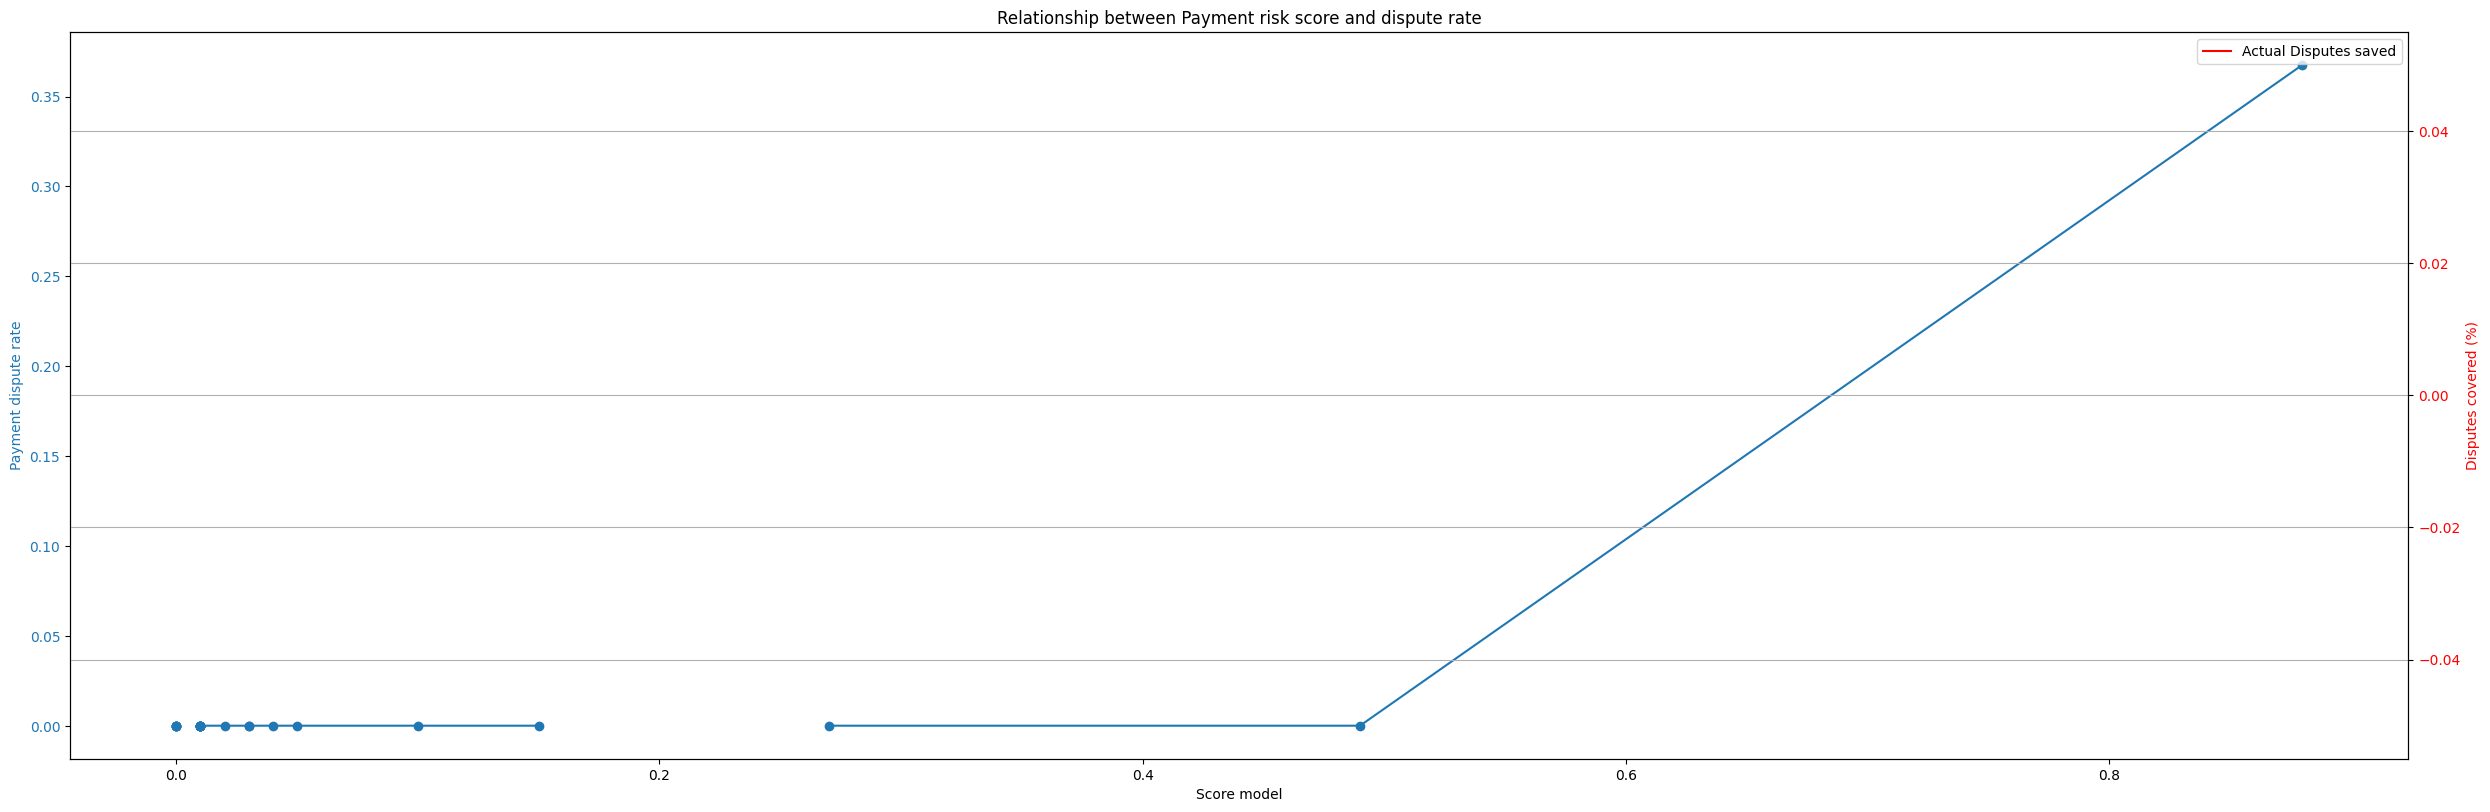

In [42]:
# Don't run
X_test_old = X_test.copy(deep = True)
X_test = X_test_old.copy(deep = True)

X_test['pred'] = Random_Forest.predict_proba(X_test[cols])[:, 1] # deleted after run
X_test['is_dispute'] = y_test # deleted after run
print(X_test['pred'].min())
print(X_test['pred'].max())
print('')

# Calculate 200 equally sized groups
quantiles = np.linspace(0, 100, 101)[:-1]  # Generate 200 equally spaced percentiles

# Calculate the actual percentiles
percentiles = np.percentile(X_test['pred'], quantiles)

# Step 1: Calculate the quantiles of 'prob' column
quantiles = X_test['pred'].quantile([i/100 for i in range(1, 101)])

# # Step 2: Calculate the mean of 'is_dispute' for each quantile range
mean_values = []
for i in range(len(quantiles)):

    lower_quantile = quantiles.reset_index(drop = True)[i]

    if i < len(quantiles) - 1:
      upper_quantile = quantiles.reset_index(drop = True)[i + 1]
    else:
      upper_quantile = 100

    subset = X_test[(X_test['pred'] >= lower_quantile) & (X_test['pred'] < upper_quantile)]
    mean_dispute = subset['is_dispute'].mean()
    mean_values.append(mean_dispute)

# Create line plot
x_values = (np.concatenate((percentiles[1:], [lower_quantile]))).round(4)[:-1]
y_values = mean_values[:-1]

# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize = (25, 8))

# Plot the first line on the first Y-axis
color = 'tab:blue'
ax1.set_xlabel('Score model')
ax1.set_ylabel('Payment dispute rate', color=color)
ax1.plot((x_values * 100).round(2), y_values, marker = 'o', color=color)
ax1.tick_params(axis='y', labelcolor = color)

# Create a secondary Y-axis for the second plot
ax2 = ax1.twinx()

quantiles = np.linspace(0, 100, 101)[:-1]  # Generate 200 equally spaced percentiles

# Calculate the actual percentiles
quantiles = np.percentile(X_test['pred'], quantiles)

# Step 2: Calculate average of 'id_dispute' for each quantile
average_id_dispute = []
for quantile in quantiles:
    avg_id_dispute = X_test[X_test['pred'] <= quantile]['is_dispute'].sum()
    average_id_dispute.append(avg_id_dispute)

# Step 3: Create line plot
x_values = (np.concatenate((quantiles[1:], [lower_quantile]))*100).round(2)[:-1]
y_values = 1 - (average_id_dispute/(average_id_dispute[-1]))[:-1]
ax2.plot(x_values, y_values, label = 'Actual Disputes saved', color = 'red')
ax2.set_ylabel('Disputes covered (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 0)
del X_test['pred']
del X_test['is_dispute']

fig.tight_layout()
plt.title('Relationship between Payment risk score and dispute rate')
plt.grid(True)
plt.show()


In [88]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

X_test['pred'] = lr.predict_proba(X_test[cols])[:, 1] # deleted after run
X_test['is_dispute'] = y_test # deleted after run

# Compute calibration curve
prob_true, prob_pred = calibration_curve(X_test['is_dispute'], X_test['pred'] , n_bins=10, strategy='uniform')

# Plot reliability diagram
plt.figure(figsize=(18, 8))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for perfect calibration
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.grid(True)
plt.show()


NotFittedError: This LogisticRegressionCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

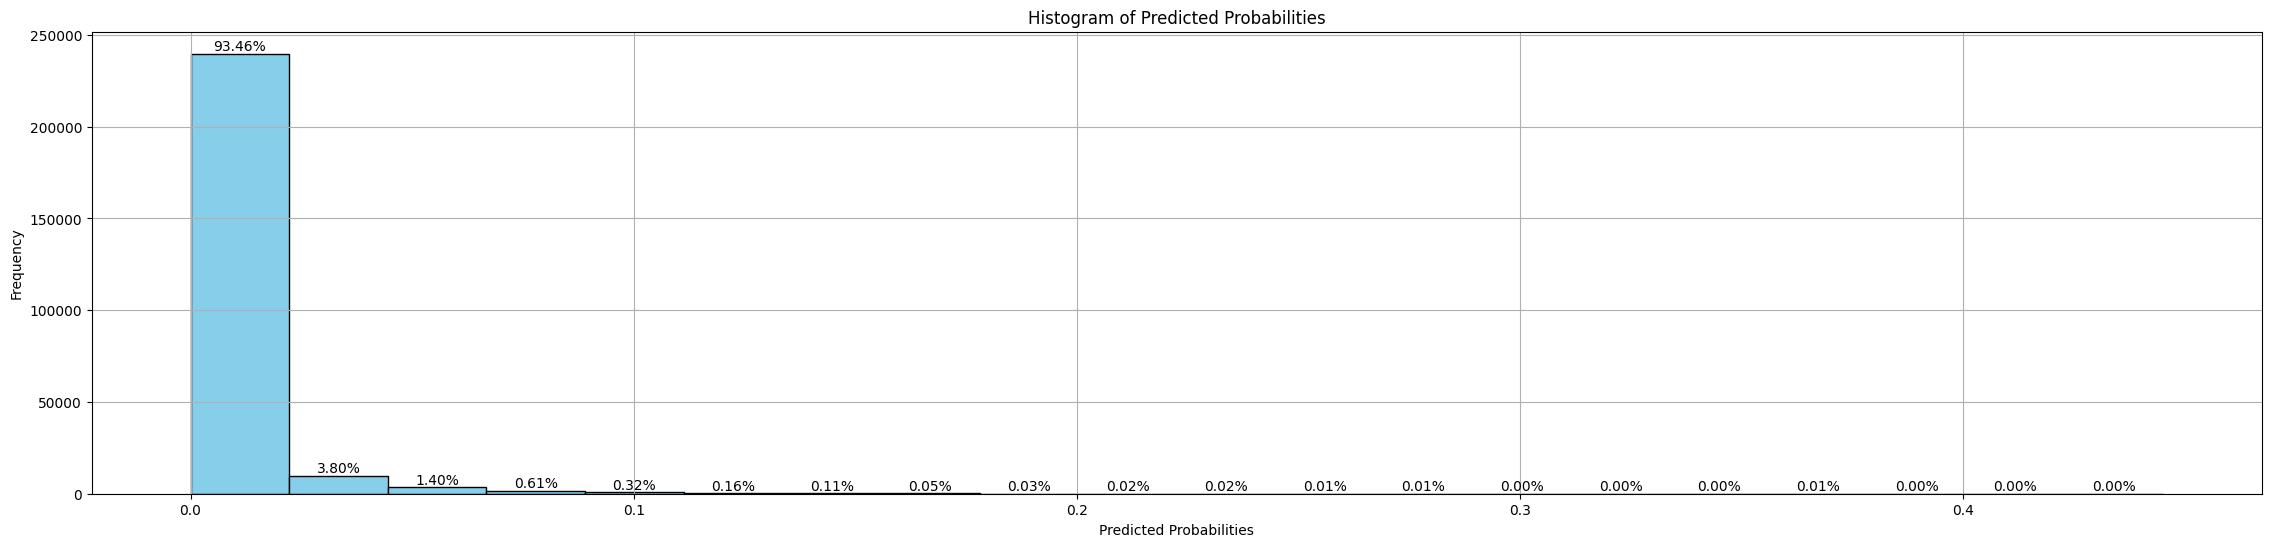

In [63]:
import matplotlib.pyplot as plt

# Assuming X_test['pred'] contains the predicted probabilities
pred_probabilities = X_test['pred']

# Plot histogram
plt.figure(figsize=(28, 6))
n, bins, patches = plt.hist(pred_probabilities, bins=20, color='skyblue', edgecolor='black')

# Compute percentages for each bin
bin_percentages = [(count / len(pred_probabilities)) * 100 for count in n]

# Add labels to bars
for patch, percentage in zip(patches, bin_percentages):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 50, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()


# Real Cross-Validation 

This part I want to implement a piece of code that breaks the training into multiple parts. Then it predicts and allocates probabilities. Subsequently it generates a visual and reports the metrics that I need to make decisions. 

For example, I want to see the number of users over time. So, I need to do the following: 

1. Break the dataset 
2. Do a model without one piece and calcualte the predictions and the actuals - You can save this 
3. Return the desired metrics - You can save this 
4. plot the results - You can save this 
5. Calcualte the overall metrics. For example, you can calculate the mean metric, and you can plot all the sampled data. 


### Break the dataset 

In [330]:
result = result[result['user_matuirity'] == 15].reset_index(drop = False)
result

,index,#account_id,register_time,payment_date,user_matuirity,first_payment_time,first_dispute_time,pull_size,time_to_payment,time_pay_to_dispute,...,max_bet_quantile_3,max_bet_quantile_4,max_bet_quantile_5,max_bet_quantile_6,max_bet_quantile_7,max_bet_quantile_8,max_bet_quantile_9,spent_to_date_outlier,spent_last_7_days_outlier,payments_to_date_outlier
0,0,10020090,2023-11-03 18:29:55.000,2023-11-19,15,2023-11-03 18:35:07.211,0,2199324,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,43,10021315,2023-11-04 22:07:35.000,2023-11-20,15,2023-11-04 22:31:23.350,0,2199324,0,0.0,...,1,1,1,0,0,0,0,1,0,1
2,69,10021680,2023-11-05 03:26:29.000,2023-11-21,15,2023-11-05 03:31:02.699,0,2199324,0,0.0,...,1,0,0,0,0,0,0,1,0,1
3,95,10023141,2023-11-06 17:18:27.000,2023-11-22,15,2023-11-20 05:58:11.995,0,2199324,811,0.0,...,1,0,0,0,0,0,0,0,0,0
4,121,10023385,2023-11-06 22:37:07.000,2023-11-22,15,2023-11-07 07:03:18.260,0,2199324,21,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38178,804342,10356664,2024-01-25 06:54:19.000,2024-02-10,15,2024-02-07 05:28:01.713,0,2199324,776,0.0,...,0,0,0,0,0,0,0,0,0,0
38179,804343,10356686,2024-01-25 06:58:50.000,2024-02-10,15,2024-01-25 08:09:02.221,0,2199324,2,0.0,...,0,0,0,0,0,0,0,0,0,0
38180,804344,10357711,2024-01-25 14:25:41.000,2024-02-10,15,2024-01-25 14:29:34.343,0,2199324,0,0.0,...,0,0,0,0,0,0,0,1,0,0
38181,804345,10357838,2024-01-25 15:09:59.000,2024-02-10,15,2024-01-25 17:05:18.093,0,2199324,4,0.0,...,0,0,0,0,0,0,0,0,0,0


In [352]:
validation_sets = 8
# result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()

validation_set_id
(20231101.999, 20231201.0]    4871
(20231201.0, 20231213.0]      5183
(20231213.0, 20231220.0]      4477
(20231220.0, 20231228.0]      4686
(20231228.0, 20240105.0]      5147
(20240105.0, 20240112.0]      4587
(20240112.0, 20240119.0]      4714
(20240119.0, 20240125.0]      4518
dtype: int64

In [353]:
result.groupby('validation_set_id')['disputer'].mean()


validation_set_id
(20231101.999, 20231201.0]    0.006980
(20231201.0, 20231213.0]      0.008103
(20231213.0, 20231220.0]      0.008041
(20231220.0, 20231228.0]      0.006615
(20231228.0, 20240105.0]      0.004663
(20240105.0, 20240112.0]      0.005014
(20240112.0, 20240119.0]      0.004031
(20240119.0, 20240125.0]      0.003099
Name: disputer, dtype: float64

Warning: The plot belows shows that there is a problem with the data utilised. Overall I think we're considereing to late users and too later payments to obtain dispute rates

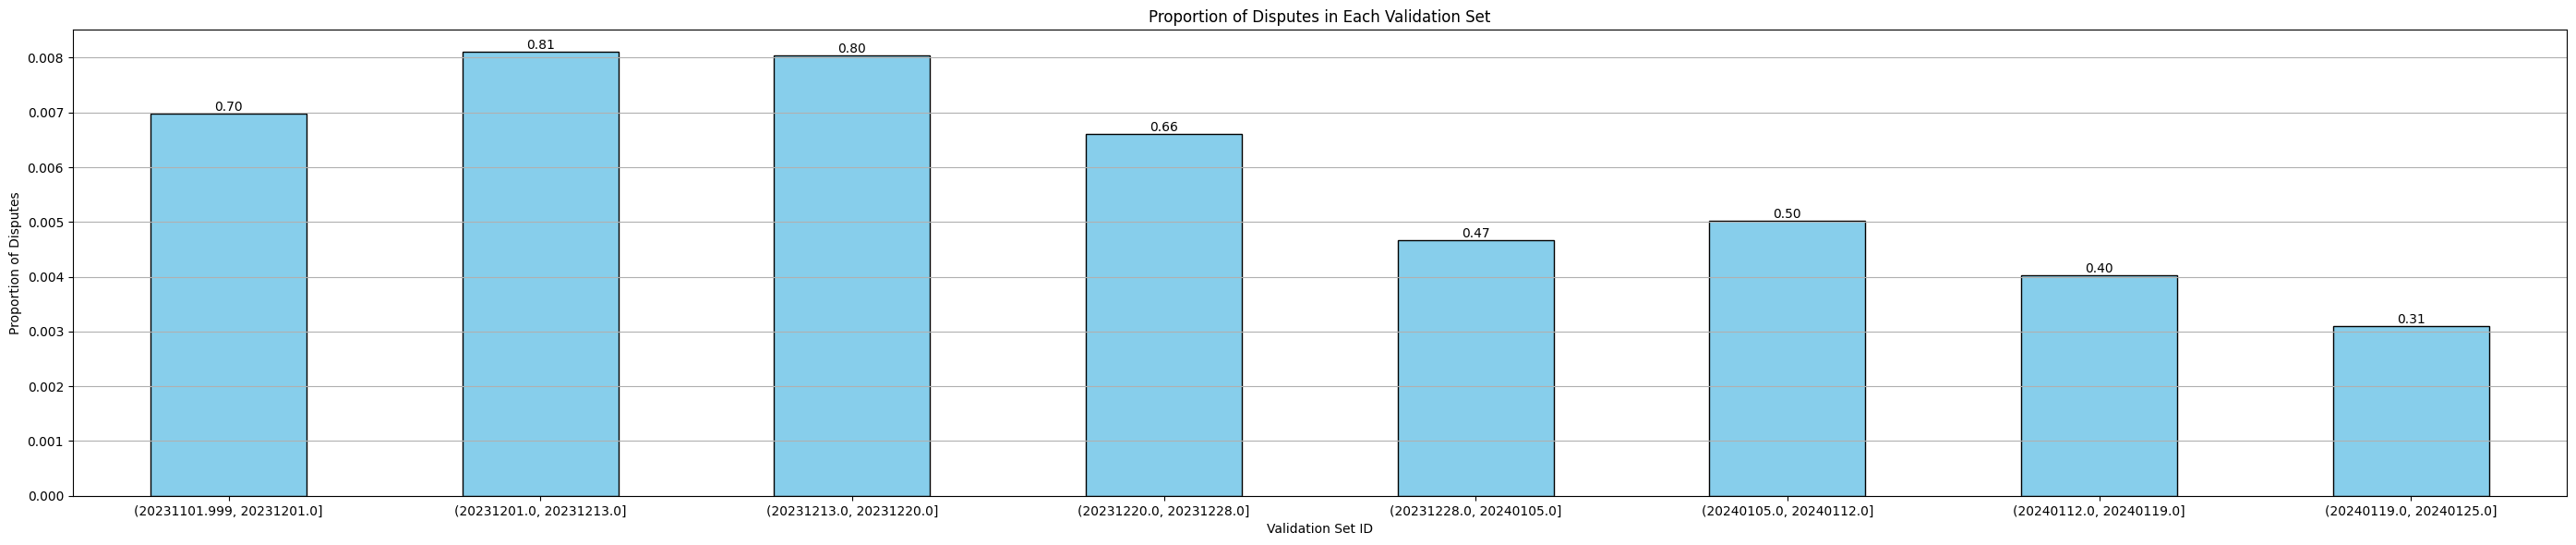

In [354]:
# validation_sets = 3

# # Convert register_time_x to datetime
# result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))

# # Create validation_set_id based on quantiles
# result['validation_set_id'] = pd.qcut(result['date'], validation_sets)

# Calculate the proportion of disputes in each group
proportion_disputes = result.groupby('validation_set_id')['disputer'].mean()

# Plot
plt.figure(figsize=(28, 6))
proportion_disputes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Validation Set ID')
plt.ylabel('Proportion of Disputes')
plt.title('Proportion of Disputes in Each Validation Set')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add gridlines only on the y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Add value labels on top of bars
for i, value in enumerate(proportion_disputes):
    plt.text(i, value, f'{value*100:.2f}', ha='center', va='bottom')

plt.show()


In [355]:
result[payment_cols]

,spent_to_date,payments_to_date,user_matuirity,payments_last_7_days,spent_last_7_days,max_payment_in_day,std_payments,l_spent_to_date,l_spent_last_7_days,l_payments_to_date,...,max_bet_quantile_4,max_bet_quantile_5,max_bet_quantile_6,max_bet_quantile_7,max_bet_quantile_8,max_bet_quantile_9,spent_to_date_outlier,spent_last_7_days_outlier,payments_to_date_outlier,disputer
0,10.00,1,15,0,0.00,10.0,0.000000,2.302585,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,206.99,46,15,34,155.99,36.0,11.170541,5.332670,5.049792,3.828641,...,1,1,0,0,0,0,1,0,1,0
2,206.00,21,15,5,48.00,43.0,15.767407,5.327876,3.871201,3.044522,...,0,0,0,0,0,0,1,0,1,0
3,2.00,1,15,1,2.00,2.0,0.000000,0.693147,0.693147,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,10.00,1,15,0,0.00,10.0,0.000000,2.302585,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38178,20.00,1,15,1,20.00,20.0,0.000000,2.995732,2.995732,0.000000,...,0,0,0,0,0,0,0,0,0,0
38179,2.00,1,15,0,0.00,2.0,0.000000,0.693147,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
38180,170.00,10,15,4,70.00,60.0,16.455568,5.135798,4.248495,2.302585,...,0,0,0,0,0,0,1,0,0,0
38181,50.00,4,15,0,0.00,50.0,0.000000,3.912023,0.000000,1.386294,...,0,0,0,0,0,0,0,0,0,0


In [356]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [
     ('rf', RandomForestClassifier(min_samples_leaf=6, random_state=42)),
     ('rf_2', RandomForestClassifier(min_samples_leaf=30, random_state=42))]

stck = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5), passthrough = True
)




models = {
    # 'RandomForest_20':           RandomForestClassifier(min_samples_leaf = 20, n_jobs = 5)
    # , 'RandomForest_10':         Ran   domForestClassifier(min_samples_leaf = 6, n_jobs = 5)
    # , 'RandomForest_400':         RandomForestClassifier(min_samples_leaf = 400, n_jobs = 5)
    'LogisticRegression':      LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5)
    # , 'Stacking':                stck  # Need to set probability=True for SVC to use predict_proba
    # , 'DecisionTree_350':       DecisionTreeClassifier(min_samples_leaf = 350)
    # , 'DecisionTree_400':       DecisionTreeClassifier(min_samples_leaf = 400)
    # , 'DecisionTree_100':       DecisionTreeClassifier(min_samples_leaf = 100)
}

# class_weight
# lr                = LogisticRegression(C = 1.0, max_iter = 180, n_jobs = 5)
# lr                = LogisticRegressionCV(max_iter = 140, l1_ratios = np.logspace(0, 1, 10), cv = 2, n_jobs = 5)
# Random_Forest_40  = RandomForestClassifier(min_samples_leaf = 40, n_jobs = 5)
# Random_Forest_200 = RandomForestClassifier(min_samples_leaf = 200, n_jobs = 5)
# dt                = DecisionTreeClassifier(min_samples_leaf = 350)

# models = [
#     (lr, "Logistic")
#     , (dt, "Classification Tree")
#     , (Random_Forest_40, "Random_Forest_40")
#     , (Random_Forest_200, "Random_Forest_200")
# ]

# Create an empty list to store results
training_results = []

# Loop through each validation set
for validation_set in tqdm(result['validation_set_id'].unique()): 

    # Remove it: 
    train_data = result[result['validation_set_id'] != validation_set][cols + ['disputer']]
    test_data  = result[result['validation_set_id'] == validation_set][cols + ['disputer']]

    # Train and predict with each model
    for model_name, model in models.items():
        X_train, y_train = train_data.drop(columns=['disputer']), train_data['disputer']
        X_test, y_test = test_data.drop(columns=['disputer']), test_data['disputer']
        model.fit(X_train[cols], y_train)
        prob_predictions = model.predict_proba(X_test[cols])[:, 1]

        # Store the predictions along with validation set and model name
        training_results.append(pd.DataFrame({
            'Validation_Set': [validation_set] * len(prob_predictions),
            f'{model_name}_Probability_Predictions': prob_predictions,
            'Actual_Labels': y_test
        }))

# Concatenate all DataFrames into one
training_results = pd.concat(training_results, ignore_index=True)
training_results


100%|██████████| 8/8 [00:43<00:00,  5.50s/it]


,Validation_Set,LogisticRegression_Probability_Predictions,Actual_Labels
0,"(20231101.999, 20231201.0]",0.010773,0
1,"(20231101.999, 20231201.0]",0.015989,0
2,"(20231101.999, 20231201.0]",0.011923,0
3,"(20231101.999, 20231201.0]",0.011713,0
4,"(20231101.999, 20231201.0]",0.010773,0
...,...,...,...
38178,"(20240119.0, 20240125.0]",0.005202,0
38179,"(20240119.0, 20240125.0]",0.002213,0
38180,"(20240119.0, 20240125.0]",0.011329,0
38181,"(20240119.0, 20240125.0]",0.003985,0


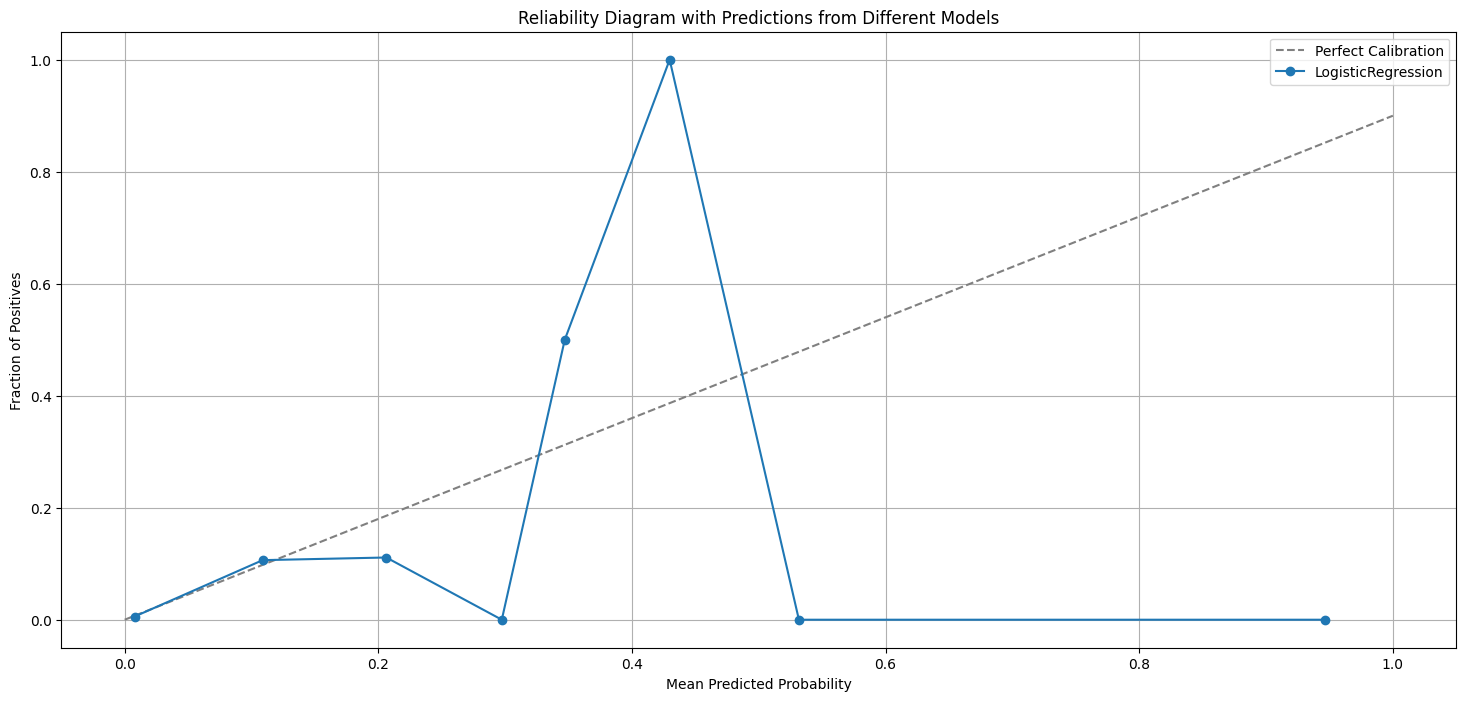

In [357]:

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute calibration curve for each model
plt.figure(figsize=(18, 8))
plt.plot([0, 1], [0, 0.9], linestyle='--', color='gray', label='Perfect Calibration')  # Diagonal line for perfect calibration

for model_name in models.keys():
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    model_actual_labels = training_results['Actual_Labels']
    
    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(model_actual_labels, model_predictions, n_bins=12, strategy='uniform')

    # Plot reliability diagram for the current model
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=model_name)

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()


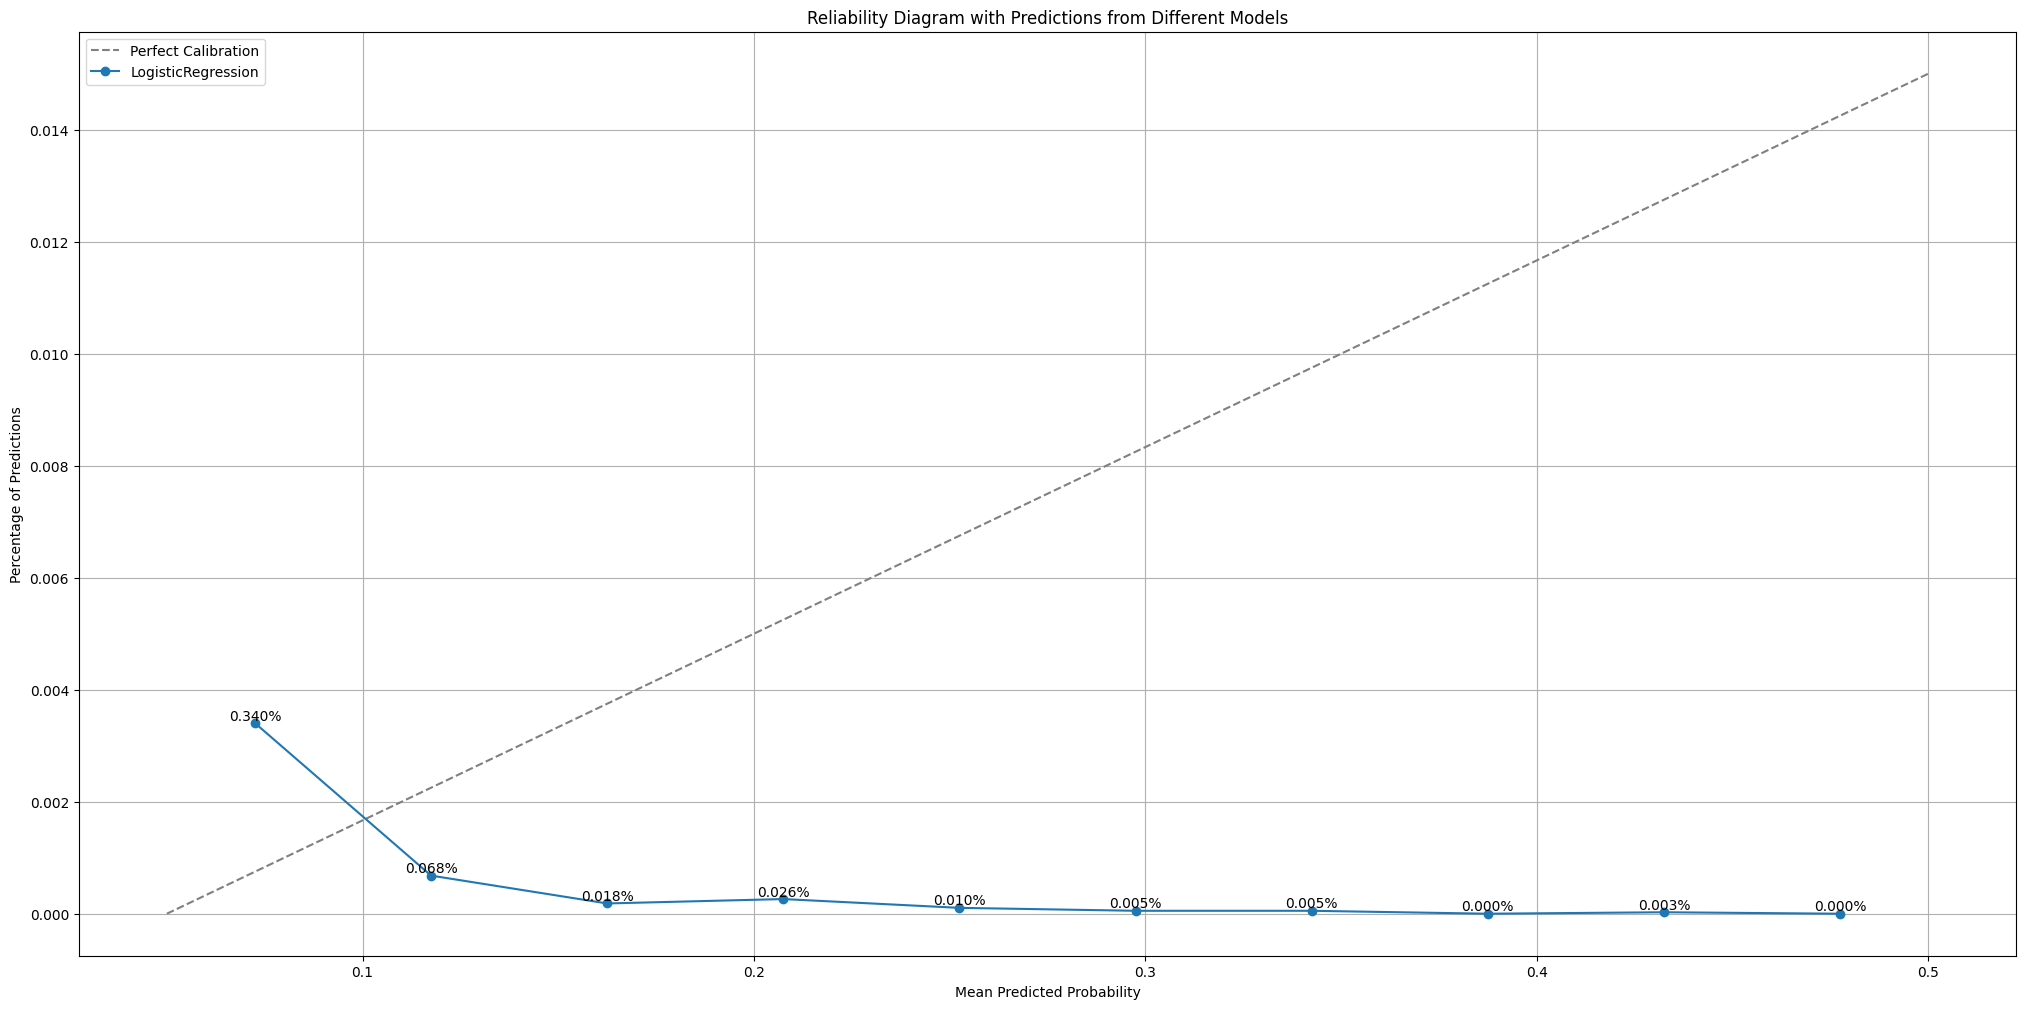

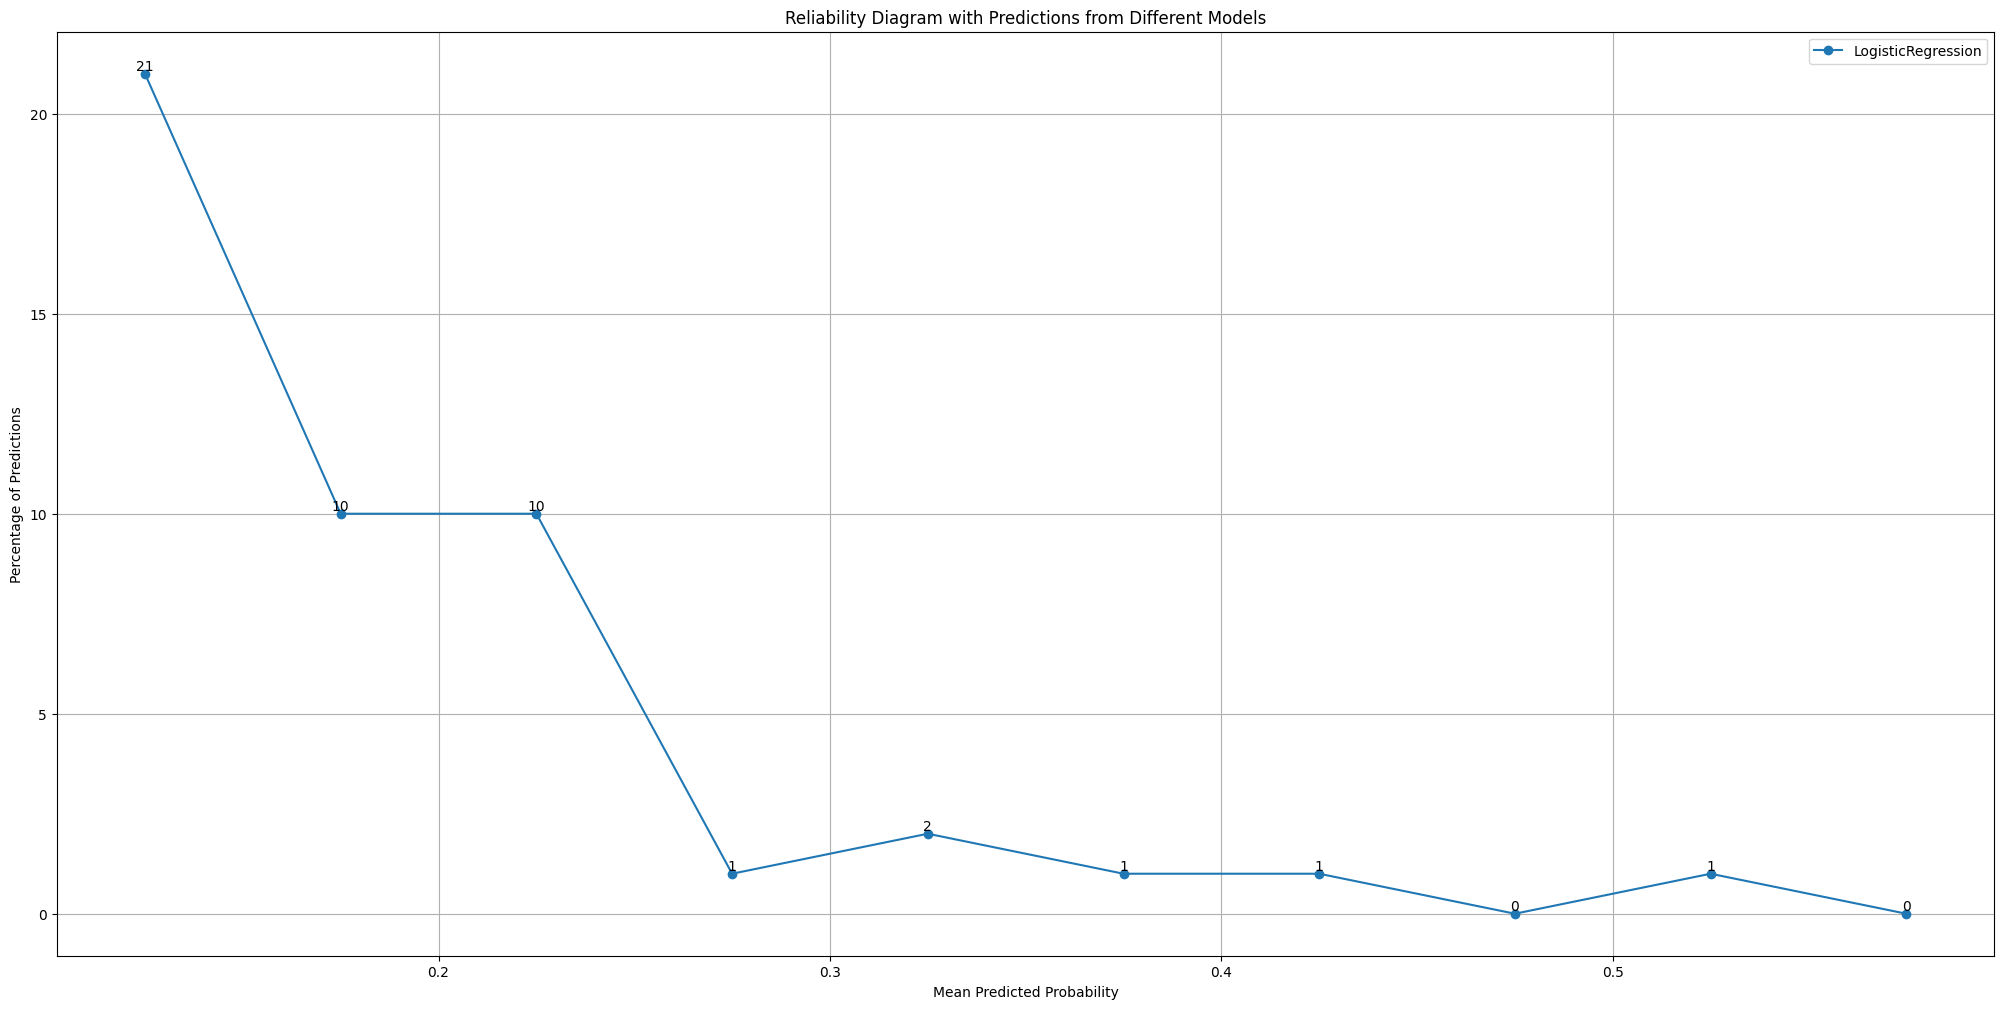

In [358]:
import numpy as np

# Compute calibration curve for each model
plt.figure(figsize=(25, 12))
plt.plot([0.05, 0.5], [0, 0.015], linestyle='--', color='gray', label='Perfect Calibration')  # Diagonal line for perfect calibration

for model_name in models.keys():
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    
    # Compute histogram of predicted probabilities
    counts, bins = np.histogram(model_predictions, bins=10, range=(0.05, 0.5))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Compute percentage of predictions in each bin
    percentages = counts / len(model_predictions)
    
    # Plot reliability diagram for the current model
    plt.plot(bin_centers, percentages,  marker='o', linestyle='-', label=model_name)

    # Add labels to the histogram bars
    for i in range(len(bin_centers)):
        plt.text(bin_centers[i], percentages[i], f'{percentages[i]*100:.3f}%', ha='center', va='bottom')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Percentage of Predictions')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(25, 12))

for model_name in models.keys():
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    
    # Compute histogram of predicted probabilities
    counts, bins = np.histogram(model_predictions, bins=10, range=(0.1, 0.6))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Compute percentage of predictions in each bin
    percentages = counts
    
    # Plot reliability diagram for the current model
    plt.plot(bin_centers, percentages,  marker='o', linestyle='-', label=model_name)

    # Add labels to the histogram bars
    for i in range(len(bin_centers)):
        plt.text(bin_centers[i], percentages[i], f'{percentages[i]}', ha='center', va='bottom')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Percentage of Predictions')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

#check ensembles: 
training_results['best_two'] = training_results['RandomForest_Probability_Predictions'] + training_results['SVC_Probability_Predictions'].fillna(0)

In [ ]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['gini', 'entropy', 'log_loss']
depths = [4,5,6, 7]
leaf_sizes = [200]
cols = ['valid_payments', 'p3', 'p7', 'p14', 'p28']
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    # old_cols = X_train.copy().columns
    # X_train = all_feature_enginerring(X_train, y_train)
    # X_test = all_feature_enginerring(X_test, y_test)

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size, cols)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)
              

              # try:
              #     model.fit(X_train[cols], y_train)
              #     predictions = model.predict(X_test[cols])
              #     accuracy = accuracy_score(y_test, predictions)
              #     prec = precision_score(y_test, predictions)

              # except:
              #     model = np.nan
              #     predictions = np.nan
              #     mae = np.nan
              #     r2 = np.nan

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])